In [ ]:
# HIDDEN
!pip install iplantuml
import iplantuml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for iplantuml: filename=IPlantUML-0.1.1-py2.py3-none-any.whl size=4906 sha256=aaa353a2bfe918d41261bb849150615fc87ecfa7f6ce54da6df2f21c7bcf0952
  Stored in directory: /root/.cache/pip/wheels/69/3e/1d/aff9f714ed0272aedc76ab9c7fa4ff2f92f2fee8e493515cf0
Successfully built iplantuml


' HIDDEN
# Uso de este notebook
Google Colab no permite modificar los metadatos de las celdas ni del notebook. Esto es un problema si vas a usar jupyter books, porque no puedes controlar cosas que son interesantes, p.ej., muchas celdas prefieres que no se generen completas (que salga el output, pero no el input). 

Un apaño es pasar un script de Python en donde se genere el jupyter book que haga limpieza. En este caso tenemos uno que busca ciertos comentarios en celdas y si están añade metadatos a estas celdas. De esa forma puedes controlar en Google Colab que celdas quieres que no salgan, aún sin tener acceso a los tags.

De momento poner esto en una celda `# NO CODE` o bien `' NO CODE` (comentarios de PlantUML) hace que de esa celda no se genere el input pero sí el output. Y poner `# HIDDEN` o `' HIDDEN` hace que esa celda no salga.

# Visión general

SITMUN es un sistema de código libre para poner en marcha sistemas de información territoriales donde múltiples usuarios puedan acceder a distintas aplicaciones según sus necesidades. Esto incluye:

- Unas aplicaciones de usuario final. 
  - La aplicación “básica” es un visor de mapas web, pero hay otras y pueden tomar formas muy distintas si es necesario.
  - En general, estas aplicaciones deben ser configuradas para resultar útiles. Esta configuración incluye indicar las herramientas específicas que van a ofrecer a sus usuarios, así como los servicios, capas o bases de datos accesibles; también incluye restricciones de acceso, basadas en usuarios, roles y territorios concretos.
    - P.ej., una aplicación puede ser el visor de mapas básico. Y si te identificas como usuario “público” del territorio “Municipio X” esa configuración describe cómo en el árbol de capas del mapa tienen que aparecer ciertos servicios web de mapas, y no otros, y no debe aparecer ninguna herramienta que permita modificar datos o acceder a BD privadas.
  - Estas aplicaciones obtienen su configuración cada vez que arrancan (porque depende del usuario, rol y territorio que se haya identificado, y porque puede haber cambiado desde la vez anterior) de una API REST. Esta API accede a la BD de SITMUN y no es la misma que usa la aplicación web de administración. Y finalmente aplican la configuración obtenida antes de permitir a los usuarios ponerse a trabajar.
- Una aplicación web de administración.
  - Esta aplicación es para que los administradores de las organizaciones que instalan SITMUN configuren las aplicaciones que quieran ofrecer a sus usuarios.
    - P.ej., podemos añadir un nuevo servicio de mapas públicamente accesible que acabamos de encontrar al visor de mapas básico para usuarios públicos de cualquier territorio. La próxima vez que un usuario público acceda verá que hay una capa más que la vez anterior.
  - Esta aplicación lee y modifica los datos en la BD de SITMUN a través de una API REST.
- Algunos componentes adicionales que se usan en varias aplicaciones, (tanto en la de administración como en las de usuario final):
  - Proxy “middleware”: es un proxy inverso para que se pueda dar acceso a servicios y bases de datos protegidos (bien sea porque están en una Intranet, y los usuarios están fuera de ella, o bien porque requieren credenciales de acceso y los usuarios no las deben conocer, o bien porque quiere modificarse la información que ofrecen antes de devolverla a la aplicación cliente, por ejemplo, enmascarando parte de una imagen con un mapa). 
    - Es un proxy inverso y por tanto el cliente no puede elegir usarlo o no, y esencialmente le resulta transparente.
  - API de autenticación: permite a los usuarios y administradores identificarse utilizando distintos mecanismos que puedan estar disponibles en las distintas organizaciones (Microsoft Active Directory, servicios LDAP y otros).

SITMUN no tiene un conjunto de datos o servicios geográficos/territoriales predefinidos. Cada despliegue de SITMUN se hace para una organización concreta, normalmente supramunicipal, y esta organización debe decidir qué aplicaciones quiere ofrecer a sus usuarios, típicamente personal técnico de los municipios, y qué servicios y datos geográficos/territoriales van a estar accesibles en estas aplicaciones. Estos servicios y bases de datos los tendrá que tener en sus propios sistemas, o bien tendrán que estar en algún sitio al que puedan acceder.

Las aplicaciones de usuario final de SITMUN interactúan relativamente poco con las API y componentes de SITMUN:
- Con la API de autenticación solo al principio, para identificar al usuario.
- Con la API de configuración solo en el arranque.
- La mayor parte de las peticiones las van a hacer contra servicios de mapas y bases de datos.
  - Las que sean intranet, protegidas etc. irán a través del Proxy “middleware”, las demás serán directas.

Esto conviene tenerlo en cuenta cuando estemos dimensionando el hardware que necesitamos para el despliegue, y cómo lo vamos a repartir.

SITMUN tiene una arquitectura de 3-tiers. Las aplicaciones web se desarrollan con Angular, Spring Boot se usa en el tier web, y una base de datos relacional (Oracle o PostgreSQL a día de hoy, pero se pueden usar otras) en el tier de datos.


# Principales componentes

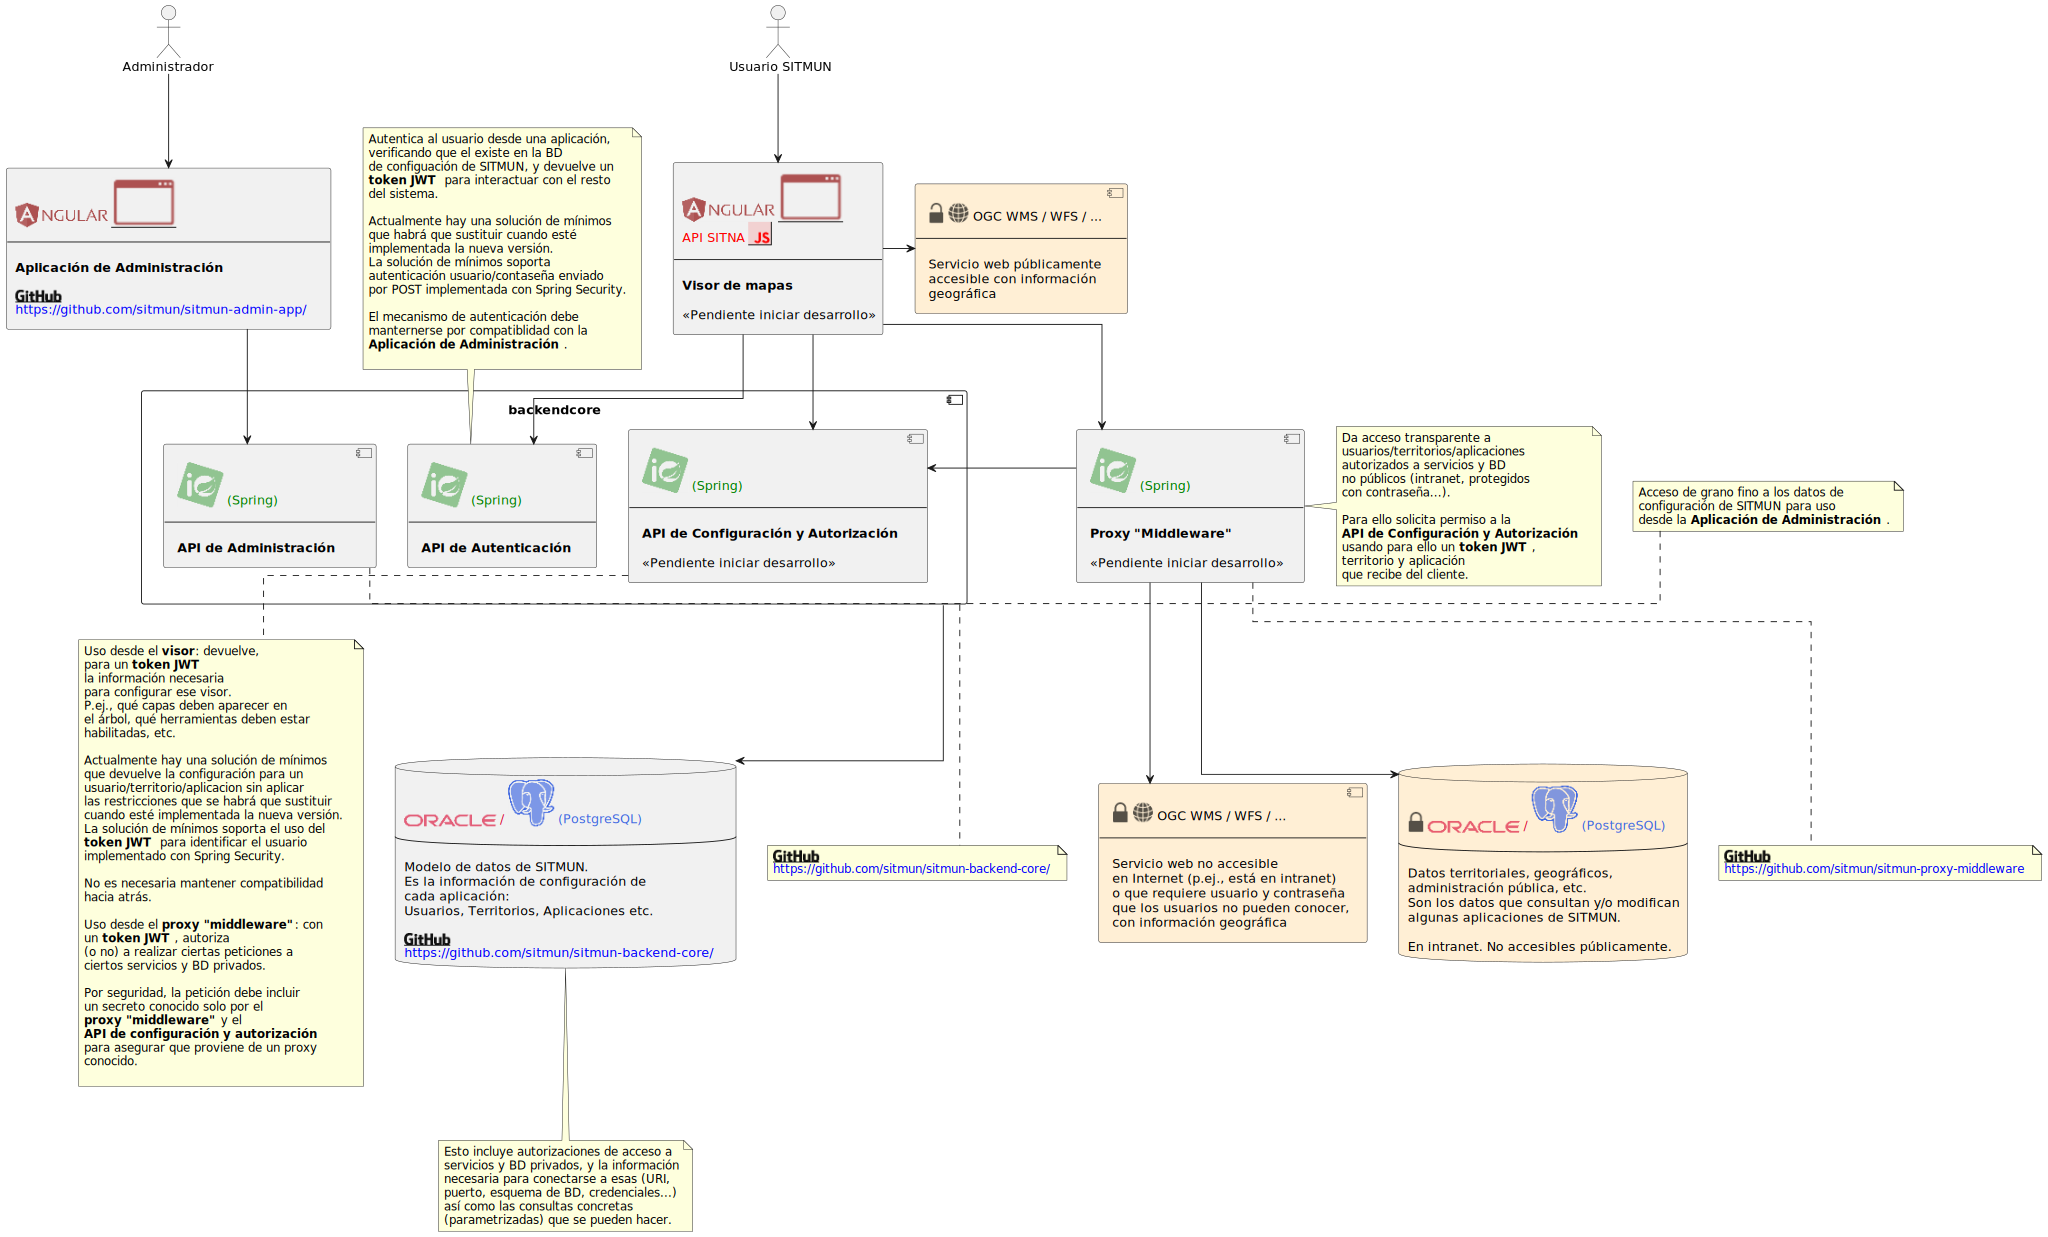

In [ ]:
%%plantuml
' NO CODE
@startuml
!include <logos/angular>
!include <logos/github>
!include <logos/javascript>
!include <logos/oracle>
!include <logos/postgresql>
!include <logos/spring>
!include <office/Concepts/application_generic>
!include <office/Concepts/globe_internet>
!include <office/Security/lock_protected>
!include <office/Security/lock_unprotected>

skinparam linetype ortho

actor Administrador
actor "Usuario SITMUN"

rectangle appadmin [
  <color:DarkRed><$angular> <$application_generic{scale=1.5}> 
  
  --
  
  **Aplicación de Administración**
  
  <$github{scale=0.5}>
  [[https://github.com/sitmun/sitmun-admin-app/]] 
]

database configdb [
  <color:Crimson><$oracle> / <color: RoyalBlue><$postgresql> (PostgreSQL)
  
  --
  
  Modelo de datos de SITMUN.
  Es la información de configuración de 
  cada aplicación:
  Usuarios, Territorios, Aplicaciones etc.
  
  <$github{scale=0.5}>
  [[https://github.com/sitmun/sitmun-backend-core/]]
]

note bottom of configdb
  Esto incluye autorizaciones de acceso a 
  servicios y BD privados, y la información
  necesaria para conectarse a esas (URI,
  puerto, esquema de BD, credenciales...)
  así como las consultas concretas 
  (parametrizadas) que se pueden hacer.
end note

rectangle visor [
  <color:DarkRed><$angular> <$application_generic{scale=1.5}>
  <color:Red>API SITNA <$javascript{scale=0.5}>
  
  --
  
  **Visor de mapas**
  
  <<Pendiente iniciar desarrollo>>
]

component publicwms #PapayaWhip [
  <$lock_unprotected{scale=0.5}> <$globe_internet{scale=0.5}> OGC WMS / WFS / ...
  
  --
  
  Servicio web públicamente
  accesible con información 
  geográfica
]

component privatewms #PapayaWhip [
  <$lock_protected{scale=0.5}> <$globe_internet{scale=0.5}> OGC WMS / WFS / ...
  
  --
  
  Servicio web no accesible 
  en Internet (p.ej., está en intranet)
  o que requiere usuario y contraseña
  que los usuarios no pueden conocer,
  con información geográfica
]

database territdb #PapayaWhip [
  <$lock_protected{scale=0.5}> <color:Crimson><$oracle> / <color: RoyalBlue><$postgresql> (PostgreSQL)
  
  --
  
  Datos territoriales, geográficos,
  administración pública, etc. 
  Son los datos que consultan y/o modifican
  algunas aplicaciones de SITMUN.
  
  En intranet. No accesibles públicamente.
]


component proxymiddleware [
  <color:Green><$spring> (Spring)
  
  --
  
  **Proxy "Middleware"**
  
  <<Pendiente iniciar desarrollo>>
]

note right of proxymiddleware
  Da acceso transparente a 
  usuarios/territorios/aplicaciones
  autorizados a servicios y BD
  no públicos (intranet, protegidos 
  con contraseña...).
  
  Para ello solicita permiso a la
  **API de Configuración y Autorización**
  usando para ello un **token JWT**, 
  territorio y aplicación
  que recibe del cliente.
end note

component backendcore {
 component apibackendcore [
  <color:Green><$spring> (Spring)
  
  --
  
  **API de Administración**    
 ]

 component apiautentic [
  <color:Green><$spring> (Spring)  
  
  --
  
  **API de Autenticación**
 ]  

 component apiconfautoriz [
  <color:Green><$spring> (Spring)
  
  --
  
  **API de Configuración y Autorización**
  
  <<Pendiente iniciar desarrollo>>  
 ]
}

note bottom of backendcore
<$github{scale=0.5}>
[[https://github.com/sitmun/sitmun-backend-core/]]
end note


note bottom of proxymiddleware
<$github{scale=0.5}>
[[https://github.com/sitmun/sitmun-proxy-middleware]]
end note

note left of apibackendcore
  Acceso de grano fino a los datos de
  configuración de SITMUN para uso 
  desde la **Aplicación de Administración**.
end note

note top of apiautentic 
  Autentica al usuario desde una aplicación,
  verificando que el existe en la BD
  de configuación de SITMUN, y devuelve un
  **token JWT** para interactuar con el resto
  del sistema.

  Actualmente hay una solución de mínimos 
  que habrá que sustituir cuando esté 
  implementada la nueva versión. 
  La solución de mínimos soporta
  autenticación usuario/contaseña enviado 
  por POST implementada con Spring Security.

  El mecanismo de autenticación debe 
  manternerse por compatiblidad con la 
  **Aplicación de Administración**.

end note

note bottom of apiconfautoriz
  Uso desde el **visor**: devuelve, 
  para un **token JWT**
  la información necesaria
  para configurar ese visor.
  P.ej., qué capas deben aparecer en
  el árbol, qué herramientas deben estar
  habilitadas, etc.
  
  Actualmente hay una solución de mínimos 
  que devuelve la configuración para un 
  usuario/territorio/aplicacion sin aplicar
  las restricciones que se habrá que sustituir 
  cuando esté implementada la nueva versión. 
  La solución de mínimos soporta el uso del
  **token JWT** para identificar el usuario
  implementado con Spring Security.  

  No es necesaria mantener compatibilidad 
  hacia atrás.

  Uso desde el **proxy "middleware"**: con
  un **token JWT**, autoriza
  (o no) a realizar ciertas peticiones a 
  ciertos servicios y BD privados.

  Por seguridad, la petición debe incluir
  un secreto conocido solo por el 
  **proxy "middleware"** y el 
  **API de configuración y autorización**
  para asegurar que proviene de un proxy
  conocido.

end note

"Usuario SITMUN" -down-> visor
Administrador -down-> appadmin
appadmin -down-> apibackendcore
backendcore -down-> configdb
visor -right-> publicwms
visor -down-> apiautentic
visor -down-> proxymiddleware
visor -down-> apiconfautoriz
proxymiddleware -down-> privatewms
proxymiddleware -down-> territdb
proxymiddleware -left-> apiconfautoriz
@enduml

# Diagramas de secuencia
En esta sección se documentan algunas de las interacciones más relevantes del sistema en forma de diagramas de secuencia.

## Login

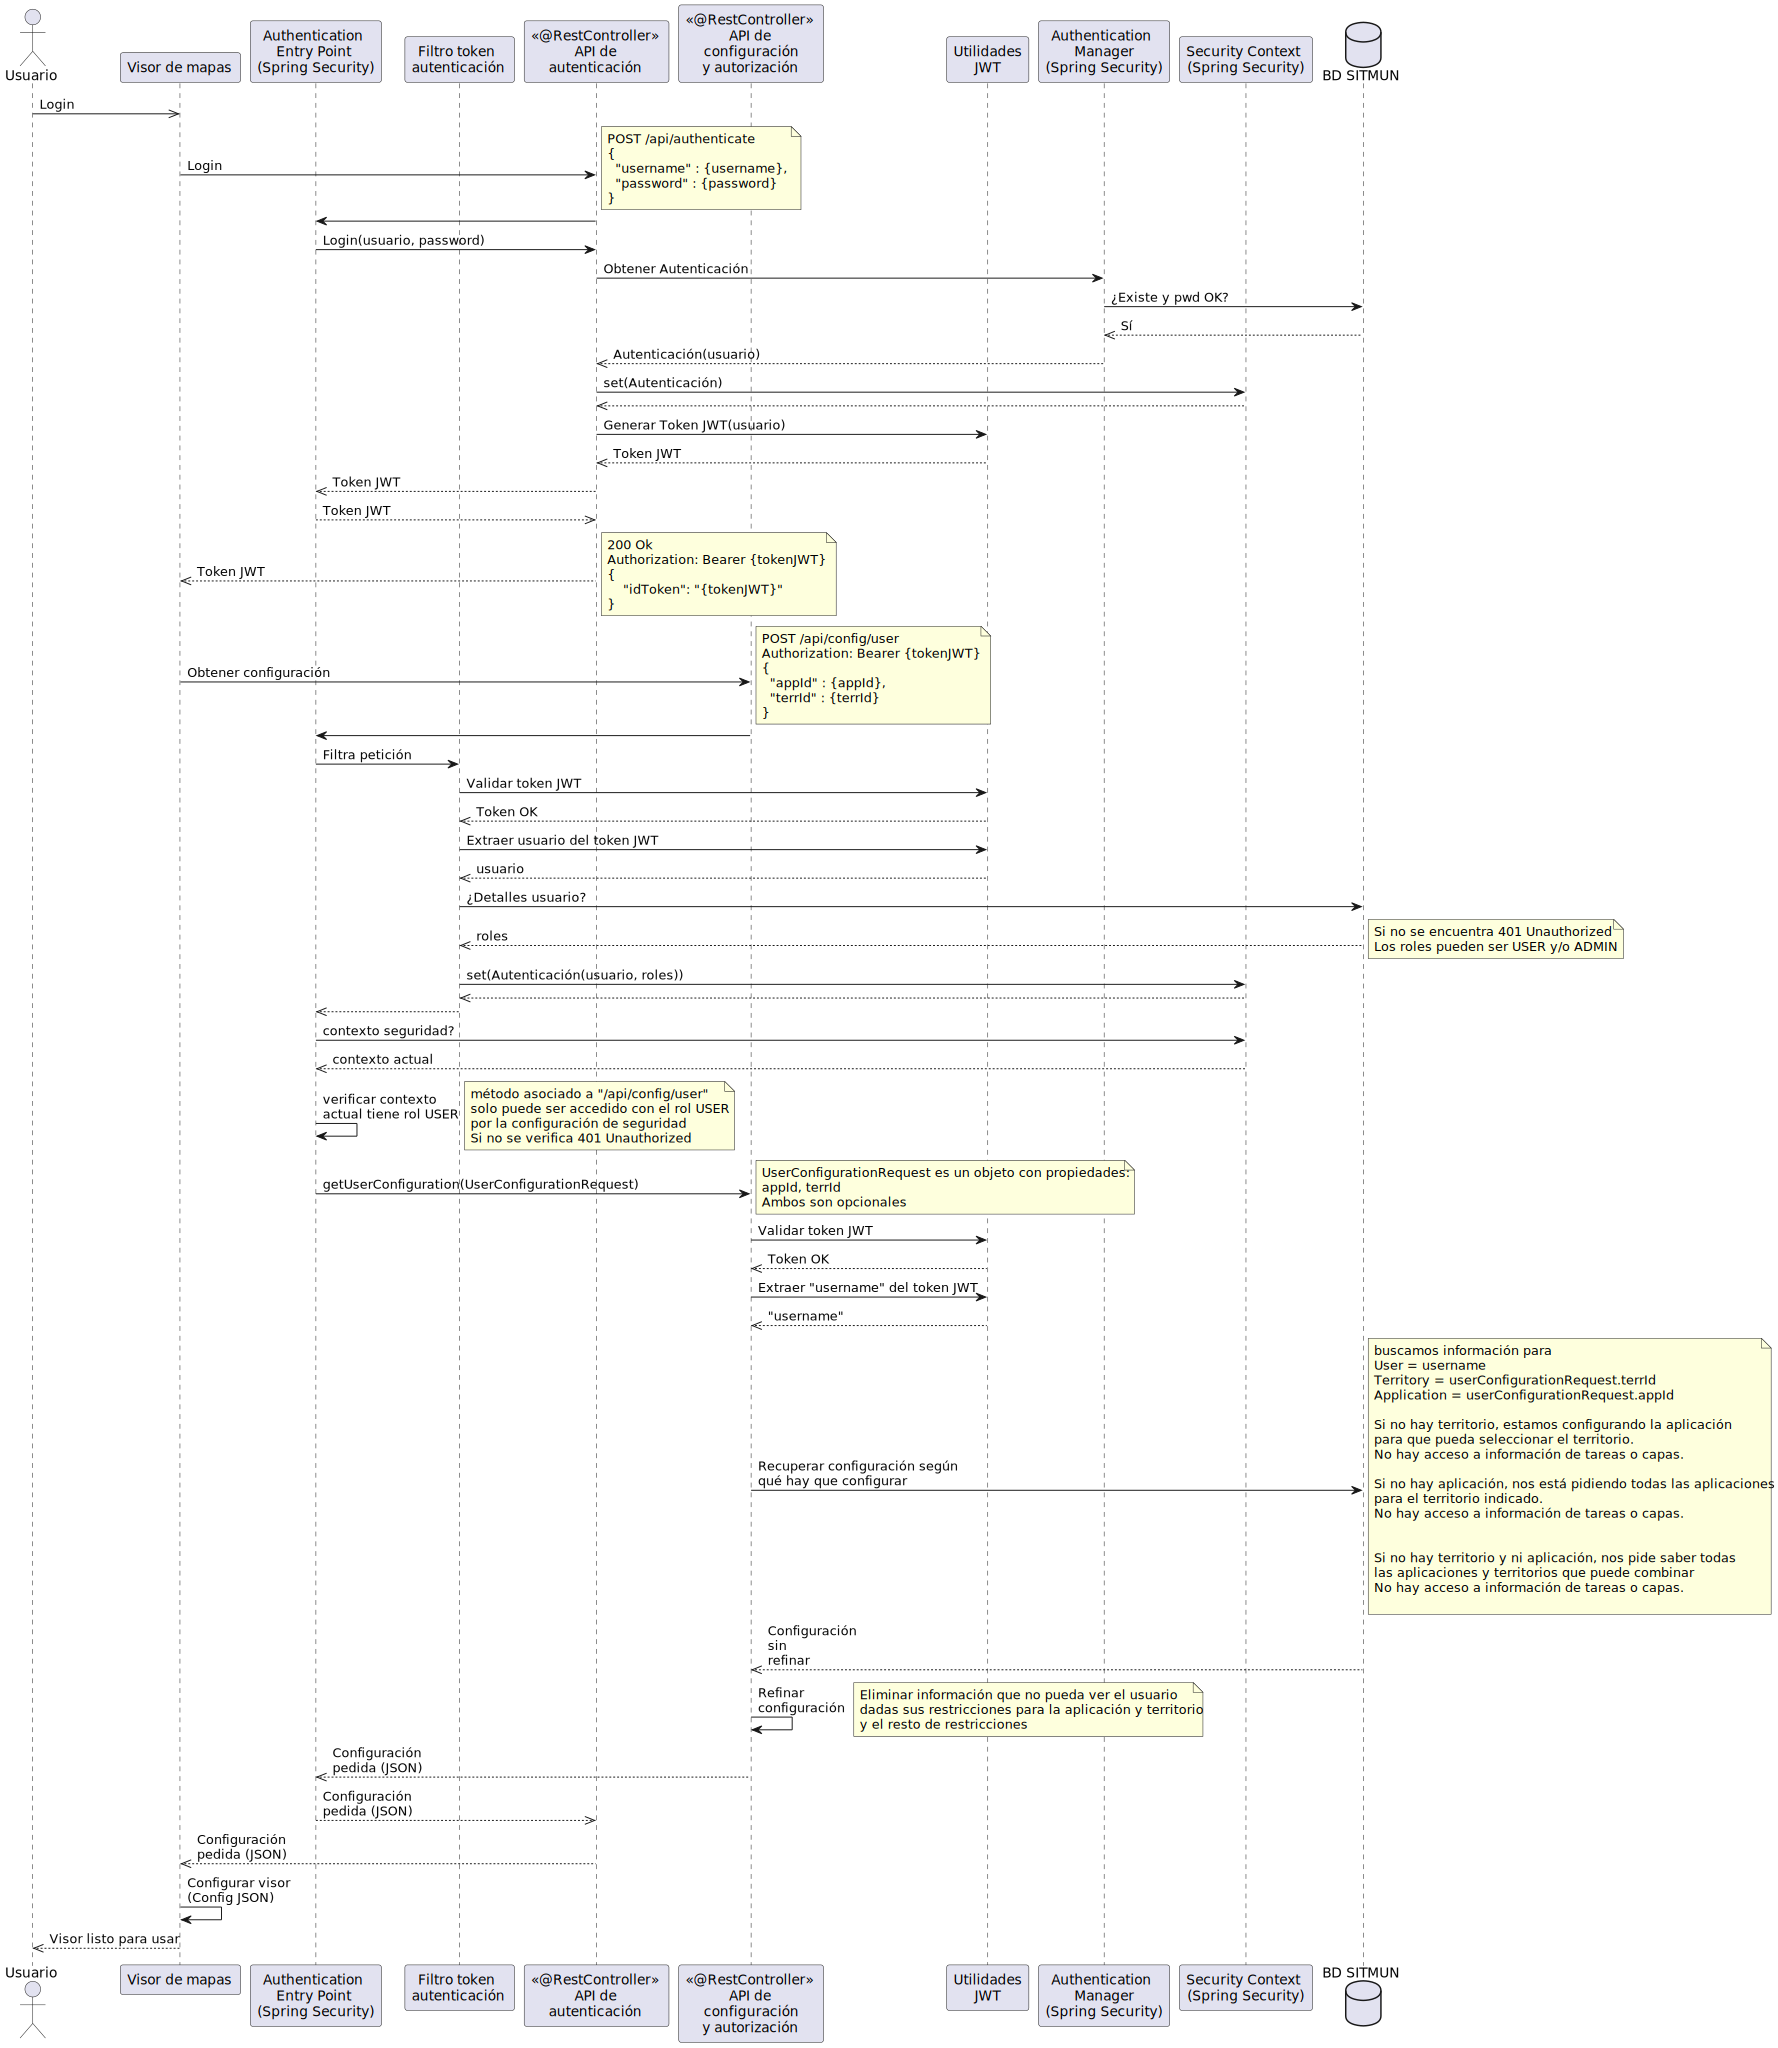

In [67]:
%%plantuml
' NO CODE
@startuml

actor Usuario
participant "Visor de mapas" as Client
participant "Authentication\nEntry Point\n(Spring Security)" as AuthenticationEntryPoint
participant "Filtro token\nautenticación" as AuthTokenFilter
participant "API de\nautenticación" as AuthenticationAPI <<@RestController>>
participant "API de\nconfiguración\ny autorización" as ConfigurationAPI <<@RestController>>
participant "Utilidades\nJWT" as JWTUtils
participant "Authentication\nManager\n(Spring Security)" as AuthenticationManager
participant "Security Context\n(Spring Security)" as SecurityContext
database "BD SITMUN" as Database

Usuario ->> Client: Login
Client -> AuthenticationAPI: Login
note right
 POST /api/authenticate 
 {
   "username" : {username},
   "password" : {password}
 }
end note

AuthenticationAPI -> AuthenticationEntryPoint
AuthenticationEntryPoint -> AuthenticationAPI: Login(usuario, password)
AuthenticationAPI-> AuthenticationManager: Obtener Autenticación
AuthenticationManager -> Database: ¿Existe y pwd OK?
Database-->> AuthenticationManager: Sí
AuthenticationManager -->> AuthenticationAPI: Autenticación(usuario)
AuthenticationAPI -> SecurityContext: set(Autenticación)
SecurityContext -->> AuthenticationAPI
AuthenticationAPI -> JWTUtils: Generar Token JWT(usuario)
JWTUtils -->> AuthenticationAPI: Token JWT
AuthenticationAPI -->> AuthenticationEntryPoint: Token JWT
AuthenticationEntryPoint -->> AuthenticationAPI: Token JWT
AuthenticationAPI -->> Client: Token JWT
note right
200 Ok
Authorization: Bearer {tokenJWT}
{
    "idToken": "{tokenJWT}"
}
end note
Client -> ConfigurationAPI: Obtener configuración 
note right
 POST /api/config/user 
 Authorization: Bearer {tokenJWT}
 {
   "appId" : {appId},
   "terrId" : {terrId}
 }
end note

ConfigurationAPI -> AuthenticationEntryPoint
AuthenticationEntryPoint -> AuthTokenFilter: Filtra petición
AuthTokenFilter -> JWTUtils: Validar token JWT
JWTUtils -->> AuthTokenFilter: Token OK
AuthTokenFilter -> JWTUtils: Extraer usuario del token JWT
JWTUtils -->> AuthTokenFilter: usuario
AuthTokenFilter-> Database: ¿Detalles usuario?
Database -->> AuthTokenFilter: roles
note right
  Si no se encuentra 401 Unauthorized
  Los roles pueden ser USER y/o ADMIN
end note
AuthTokenFilter -> SecurityContext: set(Autenticación(usuario, roles))
SecurityContext -->> AuthTokenFilter
AuthTokenFilter -->> AuthenticationEntryPoint
AuthenticationEntryPoint -> SecurityContext: contexto seguridad?
SecurityContext -->> AuthenticationEntryPoint: contexto actual
AuthenticationEntryPoint -> AuthenticationEntryPoint: verificar contexto\nactual tiene rol USER
note right
  método asociado a "/api/config/user" 
  solo puede ser accedido con el rol USER
  por la configuración de seguridad
  Si no se verifica 401 Unauthorized
end note
AuthenticationEntryPoint -> ConfigurationAPI: getUserConfiguration(UserConfigurationRequest)
note right
  UserConfigurationRequest es un objeto con propiedades:
  appId, terrId
  Ambos son opcionales
end note
ConfigurationAPI -> JWTUtils: Validar token JWT
JWTUtils -->> ConfigurationAPI: Token OK
ConfigurationAPI -> JWTUtils: Extraer "username" del token JWT
JWTUtils -->> ConfigurationAPI: "username"
ConfigurationAPI -> Database: Recuperar configuración según\nqué hay que configurar
note right
  buscamos información para 
  User = username
  Territory = userConfigurationRequest.terrId
  Application = userConfigurationRequest.appId

  Si no hay territorio, estamos configurando la aplicación 
  para que pueda seleccionar el territorio. 
  No hay acceso a información de tareas o capas.
  
  Si no hay aplicación, nos está pidiendo todas las aplicaciones
  para el territorio indicado.
  No hay acceso a información de tareas o capas.


  Si no hay territorio y ni aplicación, nos pide saber todas 
  las aplicaciones y territorios que puede combinar
  No hay acceso a información de tareas o capas.

end note
Database -->> ConfigurationAPI: Configuración\nsin\nrefinar
ConfigurationAPI -> ConfigurationAPI: Refinar\nconfiguración 
note right
  Eliminar información que no pueda ver el usuario 
  dadas sus restricciones para la aplicación y territorio
  y el resto de restricciones
end note
ConfigurationAPI -->> AuthenticationEntryPoint: Configuración\npedida (JSON)
AuthenticationEntryPoint -->> AuthenticationAPI: Configuración\npedida (JSON)
AuthenticationAPI -->> Client: Configuración\npedida (JSON)
Client -> Client: Configurar visor\n(Config JSON)
Client -->> Usuario: Visor listo para usar

@enduml

## Uso del proxy para acceder a un WMS privado

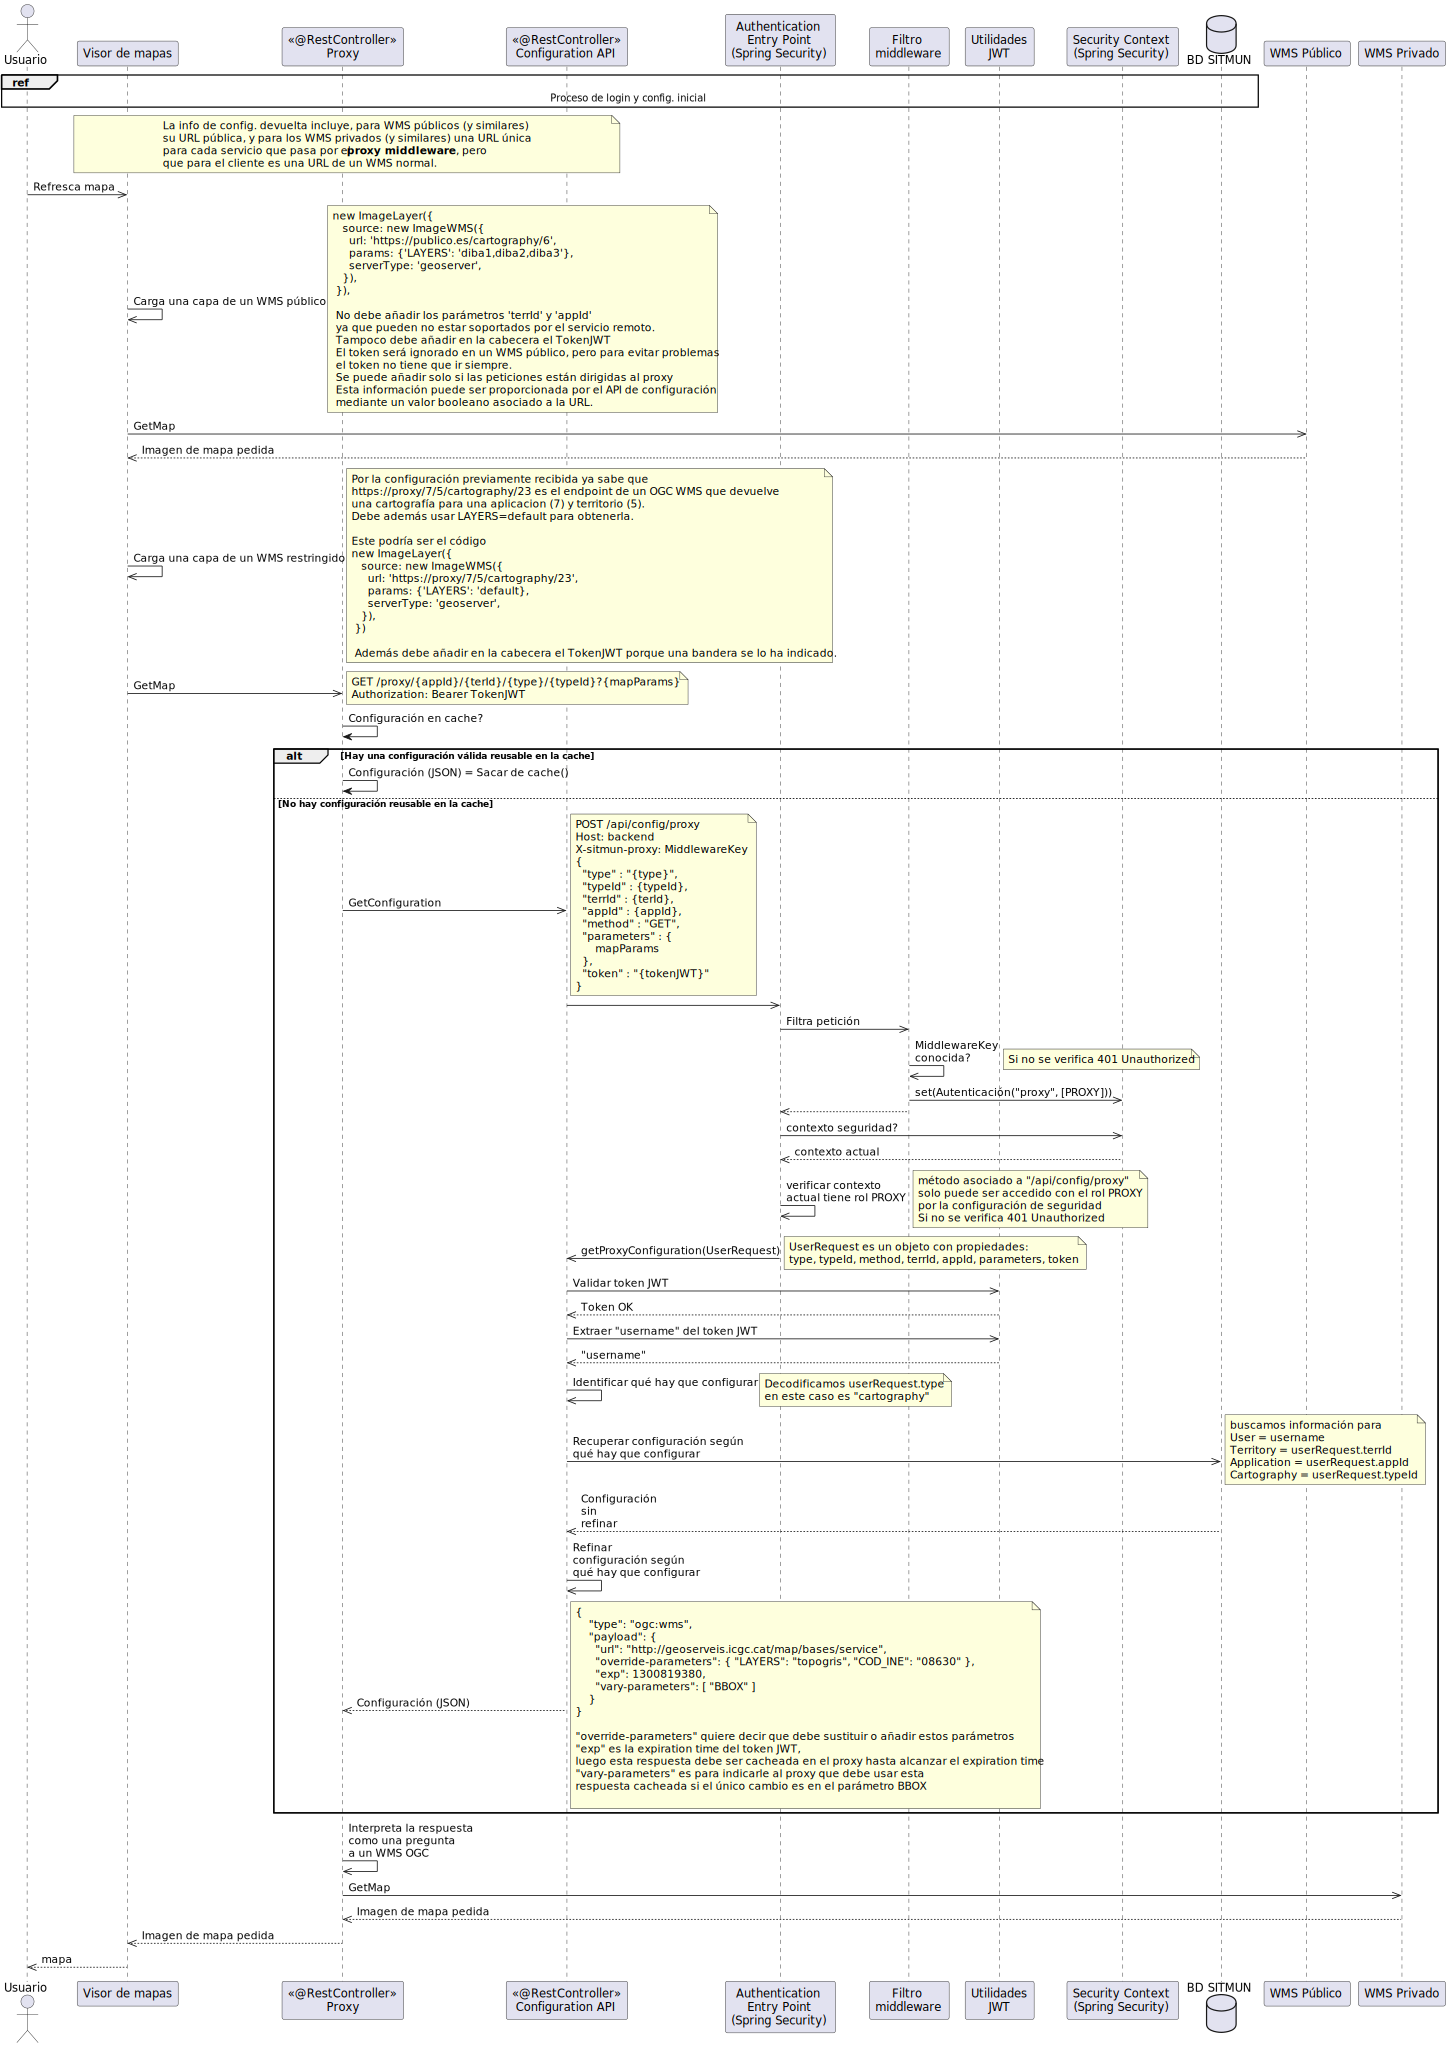

In [ ]:
%%plantuml
' NO CODE
@startuml

actor Usuario
participant "Visor de mapas" as Client
participant "Proxy" as Proxy <<@RestController>>
participant "Configuration API" as ConfigurationAPI <<@RestController>>
participant "Authentication\nEntry Point\n(Spring Security)" as AuthenticationEntryPoint
participant "Filtro \nmiddleware" as MiddlewareFilter
'participant "API de\nconfiguración\ny autorización" as ConfigurationAPI
participant "Utilidades\nJWT" as JWTUtils
participant "Security Context\n(Spring Security)" as SecurityContext
database "BD SITMUN" as Database
participant "WMS Público" as PublicWMS
participant "WMS Privado" as PrivateWMS



ref over Usuario, Client, Database : Proceso de login y config. inicial
note over Client, ConfigurationAPI
La info de config. devuelta incluye, para WMS públicos (y similares)
su URL pública, y para los WMS privados (y similares) una URL única 
para cada servicio que pasa por el **proxy middleware**, pero
que para el cliente es una URL de un WMS normal.
end note


Usuario ->> Client: Refresca mapa
Client ->> Client: Carga una capa de un WMS público
note right
 new ImageLayer({
    source: new ImageWMS({
      url: 'https://publico.es/cartography/6',
      params: {'LAYERS': 'diba1,diba2,diba3'},
      serverType: 'geoserver',
    }),
  }),

  No debe añadir los parámetros 'terrId' y 'appId' 
  ya que pueden no estar soportados por el servicio remoto.
  Tampoco debe añadir en la cabecera el TokenJWT
  El token será ignorado en un WMS público, pero para evitar problemas
  el token no tiene que ir siempre. 
  Se puede añadir solo si las peticiones están dirigidas al proxy
  Esta información puede ser proporcionada por el API de configuración
  mediante un valor booleano asociado a la URL. 
end note

Client ->> PublicWMS: GetMap

PublicWMS -->> Client: Imagen de mapa pedida
Client ->> Client: Carga una capa de un WMS restringido
note right
 Por la configuración previamente recibida ya sabe que 
 https://proxy/7/5/cartography/23 es el endpoint de un OGC WMS que devuelve
 una cartografía para una aplicacion (7) y territorio (5). 
 Debe además usar LAYERS=default para obtenerla. 

 Este podría ser el código
 new ImageLayer({
    source: new ImageWMS({
      url: 'https://proxy/7/5/cartography/23',
      params: {'LAYERS': 'default},
      serverType: 'geoserver',
    }),
  })
 
  Además debe añadir en la cabecera el TokenJWT porque una bandera se lo ha indicado. 
end note
Client ->> Proxy: GetMap
note right
 GET /proxy/{appId}/{terId}/{type}/{typeId}?{mapParams}
 Authorization: Bearer TokenJWT
end note

Proxy -> Proxy: Configuración en cache?

alt Hay una configuración válida reusable en la cache
  Proxy -> Proxy: Configuración (JSON) = Sacar de cache()

else No hay configuración reusable en la cache

  Proxy ->> ConfigurationAPI: GetConfiguration
  note right
  POST /api/config/proxy
  Host: backend
  X-sitmun-proxy: MiddlewareKey
  {
    "type" : "{type}",
    "typeId" : {typeId},
    "terrId" : {terId},
    "appId" : {appId},
    "method" : "GET",
    "parameters" : {
        mapParams
    },
    "token" : "{tokenJWT}"    
  }
  end note
  ConfigurationAPI ->> AuthenticationEntryPoint: 
  AuthenticationEntryPoint ->> MiddlewareFilter: Filtra petición
  MiddlewareFilter ->> MiddlewareFilter: MiddlewareKey\nconocida?
  note right
    Si no se verifica 401 Unauthorized
  end note
  MiddlewareFilter ->> SecurityContext: set(Autenticación("proxy", [PROXY]))
  MiddlewareFilter -->> AuthenticationEntryPoint
  AuthenticationEntryPoint ->> SecurityContext: contexto seguridad?
  SecurityContext -->> AuthenticationEntryPoint: contexto actual
  AuthenticationEntryPoint ->> AuthenticationEntryPoint: verificar contexto\nactual tiene rol PROXY
  note right
    método asociado a "/api/config/proxy" 
    solo puede ser accedido con el rol PROXY
    por la configuración de seguridad
    Si no se verifica 401 Unauthorized
  end note
  AuthenticationEntryPoint ->> ConfigurationAPI: getProxyConfiguration(UserRequest)
  note right
    UserRequest es un objeto con propiedades: 
    type, typeId, method, terrId, appId, parameters, token
  end note
  ConfigurationAPI ->> JWTUtils: Validar token JWT
  JWTUtils -->> ConfigurationAPI: Token OK
  ConfigurationAPI ->> JWTUtils: Extraer "username" del token JWT
  JWTUtils -->> ConfigurationAPI: "username"
  ConfigurationAPI ->> ConfigurationAPI: Identificar qué hay que configurar 
  note right
    Decodificamos userRequest.type
    en este caso es "cartography"
  end note
  ConfigurationAPI ->> Database: Recuperar configuración según\nqué hay que configurar
  note right
    buscamos información para 
    User = username
    Territory = userRequest.terrId
    Application = userRequest.appId
    Cartography = userRequest.typeId
  end note
  Database -->> ConfigurationAPI: Configuración\nsin\nrefinar
  ConfigurationAPI ->> ConfigurationAPI: Refinar\nconfiguración según\nqué hay que configurar
  'ConfigurationAPI -->> AuthenticationEntryPoint: Configuración\npedida (JSON)
  
  'AuthenticationEntryPoint -->> ConfigurationAPI: Configuración\npedida (JSON)
  ConfigurationAPI -->> Proxy: Configuración (JSON)

  note right
    {
        "type": "ogc:wms",
        "payload": {
          "url": "http://geoserveis.icgc.cat/map/bases/service",
          "override-parameters": { "LAYERS": "topogris", "COD_INE": "08630" },
          "exp": 1300819380,
          "vary-parameters": [ "BBOX" ]
        }
    }

    "override-parameters" quiere decir que debe sustituir o añadir estos parámetros
    "exp" es la expiration time del token JWT, 
    luego esta respuesta debe ser cacheada en el proxy hasta alcanzar el expiration time
    "vary-parameters" es para indicarle al proxy que debe usar esta 
    respuesta cacheada si el único cambio es en el parámetro BBOX

  end note

end

Proxy ->> Proxy: Interpreta la respuesta\ncomo una pregunta\na un WMS OGC
Proxy ->> PrivateWMS: GetMap
PrivateWMS -->> Proxy: Imagen de mapa pedida
Proxy -->> Client: Imagen de mapa pedida
Client -->> Usuario: mapa


@enduml

## Uso del proxy para acceder a una BD en Intranet

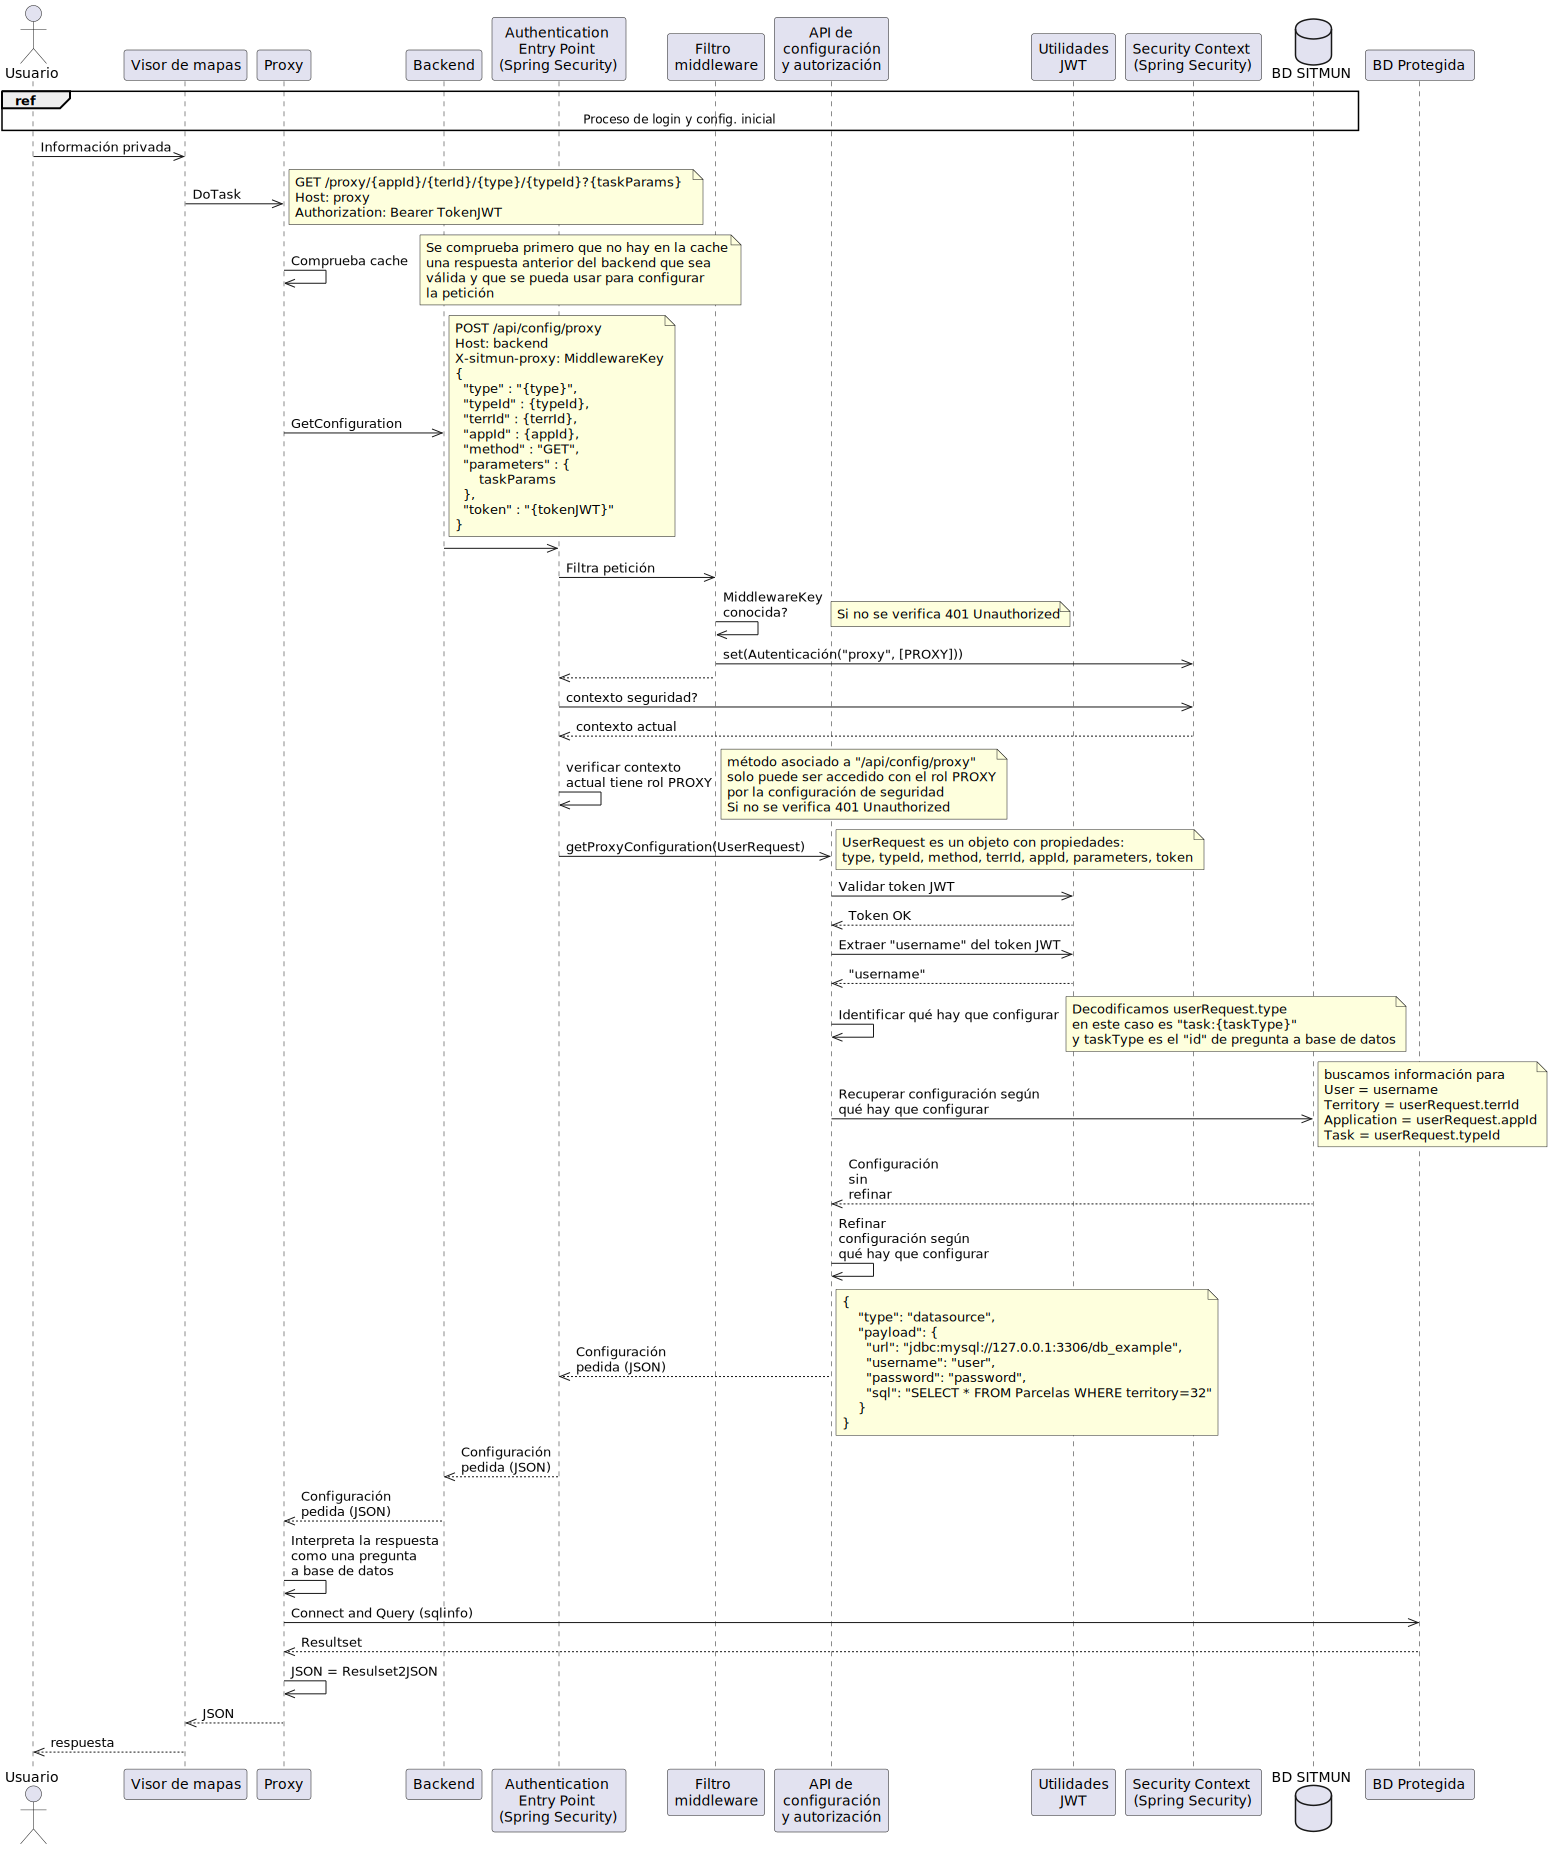

In [ ]:
%%plantuml
' NO CODE
@startuml

actor Usuario
participant "Visor de mapas" as Client
participant "Proxy" as Proxy
participant "Backend" as Backend
participant "Authentication\nEntry Point\n(Spring Security)" as AuthenticationEntryPoint
participant "Filtro \nmiddleware" as MiddlewareFilter
participant "API de\nconfiguración\ny autorización" as ConfigurationAPI
participant "Utilidades\nJWT" as JWTUtils
participant "Security Context\n(Spring Security)" as SecurityContext
database "BD SITMUN" as Database
participant "BD Protegida" as ProtectedDatabase

ref over Usuario, Database : Proceso de login y config. inicial

Usuario ->> Client: Información privada
Client ->> Proxy: DoTask
note right
 GET /proxy/{appId}/{terId}/{type}/{typeId}?{taskParams}
 Host: proxy
 Authorization: Bearer TokenJWT
end note
Proxy ->> Proxy: Comprueba cache
note right
 Se comprueba primero que no hay en la cache
 una respuesta anterior del backend que sea 
 válida y que se pueda usar para configurar
 la petición
end note
Proxy ->> Backend: GetConfiguration
note right
 POST /api/config/proxy
 Host: backend
 X-sitmun-proxy: MiddlewareKey
 {
   "type" : "{type}",
   "typeId" : {typeId},
   "terrId" : {terrId},
   "appId" : {appId},
   "method" : "GET",
   "parameters" : {
       taskParams
   },
   "token" : "{tokenJWT}"    
 }
end note

Backend ->> AuthenticationEntryPoint: 
AuthenticationEntryPoint ->> MiddlewareFilter: Filtra petición
MiddlewareFilter ->> MiddlewareFilter: MiddlewareKey\nconocida?
note right
  Si no se verifica 401 Unauthorized
end note
MiddlewareFilter ->> SecurityContext: set(Autenticación("proxy", [PROXY]))
MiddlewareFilter -->> AuthenticationEntryPoint
AuthenticationEntryPoint ->> SecurityContext: contexto seguridad?
SecurityContext -->> AuthenticationEntryPoint: contexto actual
AuthenticationEntryPoint ->> AuthenticationEntryPoint: verificar contexto\nactual tiene rol PROXY
note right
  método asociado a "/api/config/proxy" 
  solo puede ser accedido con el rol PROXY
  por la configuración de seguridad
  Si no se verifica 401 Unauthorized
end note
AuthenticationEntryPoint ->> ConfigurationAPI: getProxyConfiguration(UserRequest)
note right
  UserRequest es un objeto con propiedades: 
  type, typeId, method, terrId, appId, parameters, token
end note
ConfigurationAPI ->> JWTUtils: Validar token JWT
JWTUtils -->> ConfigurationAPI: Token OK
ConfigurationAPI ->> JWTUtils: Extraer "username" del token JWT
JWTUtils -->> ConfigurationAPI: "username"
ConfigurationAPI ->> ConfigurationAPI: Identificar qué hay que configurar 
note right
  Decodificamos userRequest.type
  en este caso es "task:{taskType}"
  y taskType es el "id" de pregunta a base de datos
end note
ConfigurationAPI ->> Database: Recuperar configuración según\nqué hay que configurar
note right
  buscamos información para 
  User = username
  Territory = userRequest.terrId
  Application = userRequest.appId
  Task = userRequest.typeId
end note
Database -->> ConfigurationAPI: Configuración\nsin\nrefinar
ConfigurationAPI ->> ConfigurationAPI: Refinar\nconfiguración según\nqué hay que configurar
ConfigurationAPI -->> AuthenticationEntryPoint: Configuración\npedida (JSON)
note right
  {
      "type": "datasource",
      "payload": {
        "url": "jdbc:mysql://127.0.0.1:3306/db_example",
        "username": "user",
        "password": "password",
        "sql": "SELECT * FROM Parcelas WHERE territory=32"
      }
  }
end note
AuthenticationEntryPoint -->> Backend: Configuración\npedida (JSON)
Backend -->> Proxy: Configuración\npedida (JSON)
Proxy ->> Proxy: Interpreta la respuesta\ncomo una pregunta\na base de datos
Proxy ->> ProtectedDatabase: Connect and Query (sqlinfo)
ProtectedDatabase -->> Proxy: Resultset
Proxy ->> Proxy: JSON = Resulset2JSON
Proxy -->> Client: JSON
Client -->> Usuario: respuesta

@enduml

## Diagrama de paquetes/clases principales de sitmun-backend-core
Explicar lo que hay. Lo más urgente es el punto de vista de Guadaltel: qué necesitan tocar y qué no. Pero en general, ver lo que hay, hacer limpieza, puede que separar alguna cosa a otro sitio...

' HIDDEN

### Diagrama de módulos
[sitmun-backend-core](https://github.com/sitmun/sitmun-backend-core) es un proyecto multimódulo.

Hay 3 tipos de módulos:
- **Módulos estables (en amarillo)**. Lógica principal de SITMUN y componentes de soporte.
- **Módulos de desarrollo (en naranja)**. Datos de prueba, despliegues de prueba y herramientas de apoyo (front end y línea de comandos).
- **Módulos legados (en gris)**. Clases y funcionalidades que se han ido desechando pero que todavía no han sido eliminadas definitivamente. 

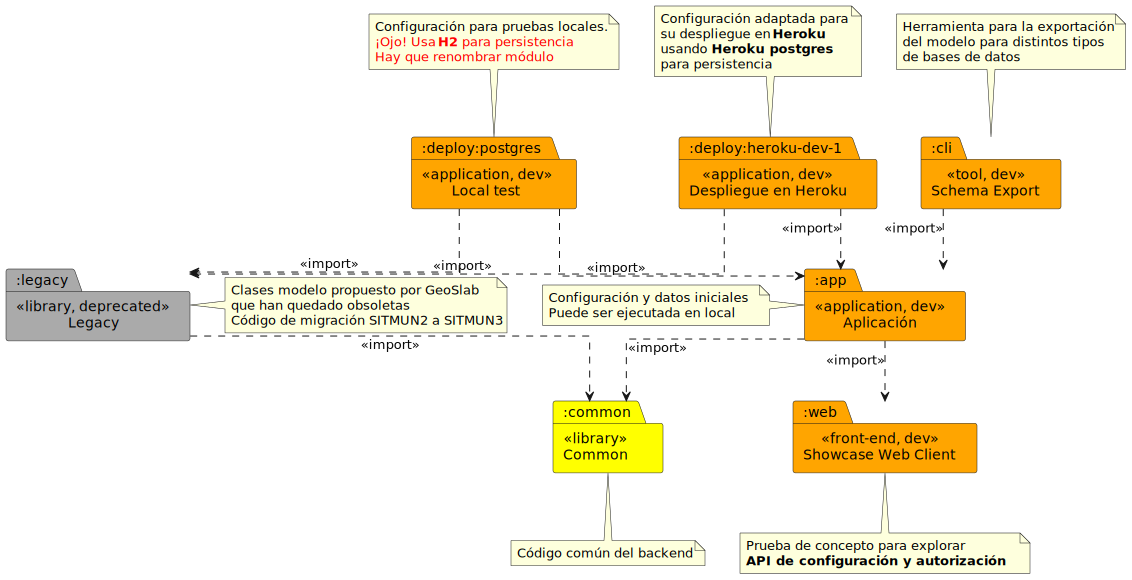

In [68]:
%%plantuml
' HIDDEN
@startuml

skinparam linetype ortho

together {
  package "Showcase Web Client" <<front-end, dev>> as ":web" #ffa500 { 
  }
  note bottom of ":web"
    Prueba de concepto para explorar
    <b>API de configuración y autorización</b>
  end note
  package "Common" <<library>> as ":common" #FFFF00	 {
  }
  note bottom of ":common" 
    Código común del backend
  end note
}

together {
  package "Legacy" <<library, deprecated>> as ":legacy"  #AAAAAA {
  }
  note right of ":legacy"
    Clases modelo propuesto por GeoSlab
    que han quedado obsoletas
    Código de migración SITMUN2 a SITMUN3
  end note
  package "Aplicación" <<application, dev>> as ":app" #ffa500 {
  }
  note left of ":app"
    Configuración y datos iniciales   
    Puede ser ejecutada en local
  end note
}

together {
  package "Despliegue en Heroku" <<application, dev>> as ":deploy:heroku-dev-1" #ffa500  {
    
  }

  note top of ":deploy:heroku-dev-1"
    Configuración adaptada para
    su despliegue en **Heroku**
    usando **Heroku postgres**
    para persistencia
  end note

  package "Local test" <<application, dev>> as ":deploy:postgres" #ffa500 {
     
  }

  note top of ":deploy:postgres"
    Configuración para pruebas locales.
    <color:red>¡Ojo! Usa **H2** para persistencia</color>
    <color:red>Hay que renombrar módulo</color>
  end note

  package "Schema Export" <<tool, dev>> as ":cli" #ffa500  {
    
  }
  
  note top of ":cli"
    Herramienta para la exportación
    del modelo para distintos tipos
    de bases de datos
  end note
}


":deploy:postgres" ..> ":legacy" : <<import>>
":deploy:postgres" ..> ":app" : <<import>>

":deploy:heroku-dev-1" ..> ":app" : <<import>>
":deploy:heroku-dev-1" .[norank].> ":legacy" : <<import>>

":cli" .r.> ":app" : <<import>>

":app" ..> ":web" : <<import>>
":app" ..> ":common" : <<import>>

":legacy" ..> ":common" : <<import>>

@enduml

### Diagrama de paquetes

Es la librería que contiene la definición del modelo de datos de SITMUN, la API de autenticación, la API de configuración y autorización y la política de seguridad.


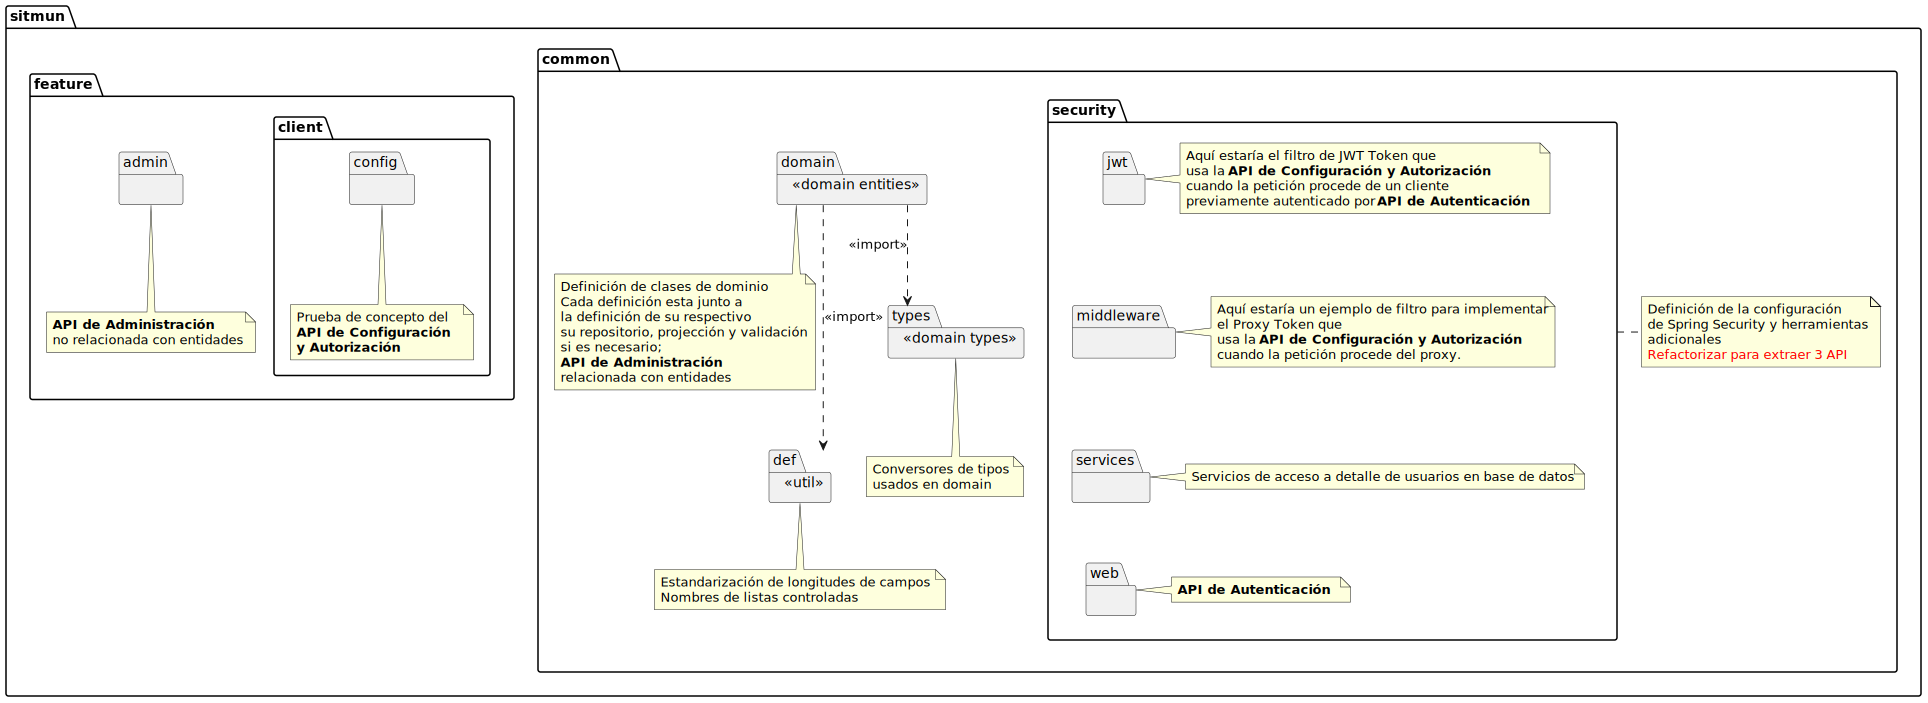

In [ ]:
%%plantuml
' NO CODE
@startuml
skinparam linetype ortho
package "sitmun" {
    package "common" {
      package "def" <<util>> {

      } 
      note bottom of "def"
        Estandarización de longitudes de campos 
        Nombres de listas controladas
      end note
      package "domain" <<domain entities>> {

      } 
      note bottom of "domain"
        Definición de clases de dominio
        Cada definición esta junto a
        la definición de su respectivo
        su repositorio, projección y validación
        si es necesario;
        **API de Administración** 
        relacionada con entidades
      end note
      package "types" <<domain types>> {

      } 
      note bottom of "types"
        Conversores de tipos
        usados en domain
      end note
      "domain".d.->"def": <<import>>
      "domain".d.>"types": <<import>>

      package "security" {
        package "jwt" {

        } 
        note right of "jwt"
          Aquí estaría el filtro de JWT Token que 
          usa la **API de Configuración y Autorización**
          cuando la petición procede de un cliente 
          previamente autenticado por **API de Autenticación**
        end note
        package "middleware" {

        } 
        note right of "middleware"
          Aquí estaría un ejemplo de filtro para implementar
          el Proxy Token que 
          usa la **API de Configuración y Autorización**
          cuando la petición procede del proxy.
        end note
        package "services" {

        } 
        note right of "services"
          Servicios de acceso a detalle de usuarios en base de datos
        end note
        package "web" {

        } 
        note right of "web"
          **API de Autenticación**
        end note
        
       "jwt"-d[hidden]->"middleware"
       "middleware"-d[hidden]->"services"
       "services"-d[hidden]->"web"
      } 
      note bottom of "security"
        Definición de la configuración 
        de Spring Security y herramientas
        adicionales
        <color:red>Refactorizar para extraer 3 API</color>
      end note
    }
    package "feature" {
      package "admin" {
        
      }
      note bottom of "admin"
        **API de Administración** 
        no relacionada con entidades
      end note
      package "client" {
        package "config" {
        
        }
        note bottom of "config"
          Prueba de concepto del 
          **API de Configuración** 
          **y Autorización**
        end note
      }
    }
}
@enduml

' HIDDEN
### Propuesta de refactorización

' HIDDEN

#### Paquetes (Arquitectura por Capas)
En general cada API que en despliegue quede expuesta de manera separad, con su propio endpoint HTTP, tiene un paquete. Y cada uno de estos paquetes tiene los controladores y otras cosas necesarias para implementar ese endpoint HTTP subpaquete `web`, las clases de infraestructura (de biblioteca) de Spring, típicamente anotadas con `@Config`, `@Component`, `@Bean` en un subpaquete `config` y, las API que necesitan una capa de servicios de aplicación (servicios a los que se invocará desde los endpoints) tienen un subpaquete `services`.

Además de las API hay un paquete `domain` con las clases del dominio SITMUN (recordatorio: el dominio de SITMUN es la configuración de aplicaciones de gestión territorial, no los datos o servicios territoriales, que son externos a SITMUN), y un paquete `security` QUE NO TENGO AÚN MUY CLARO.


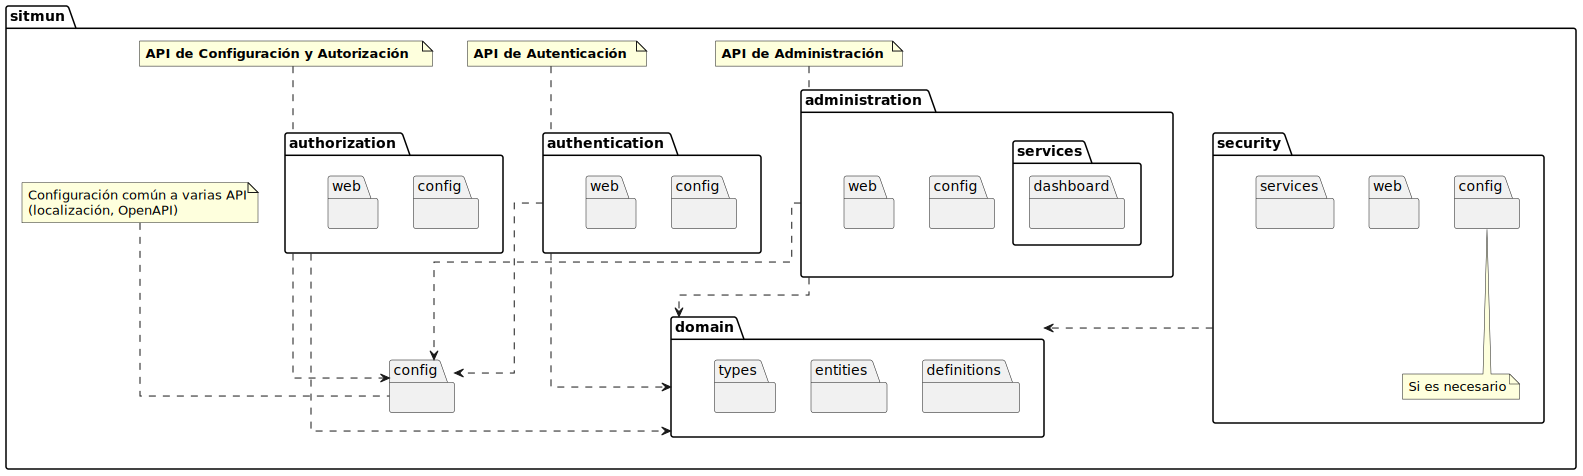

In [50]:
%%plantuml
' HIDDEN
@startuml Refactor
skinparam linetype ortho
package sitmun {
    package authentication {
        package config {
            
        }
        package web {
        }
    }
    note top of authentication: **API de Autenticación**
    package authorization {
        package config {
            
        }
        package web {
        }
    }
    note top of authorization: **API de Configuración y Autorización**
    package administration {
        package config {
            
        }
        package web {
        }
        package services {
            package dashboard {                
            }
        }
    }
    note top of administration: **API de Administración**
    package config {
    }
    note top of config
      Configuración común a varias API
      (localización, OpenAPI)      
    end note
    package security {
        package config {
            
        }
        note bottom of config
          Si es necesario
        end note
        package web {
        }
        package services {
        }
    }
    package domain {
        package definitions {
        }        
        package entities {
        }        
        package types {            
        }        
    }
}

administration .down.> domain
authorization .down.> domain
authentication .down.> domain
security .down.> domain
administration .down.> sitmun.config
authorization .down.> sitmun.config
authentication .down.> sitmun.config

@enduml

' HIDDEN

#### Clases

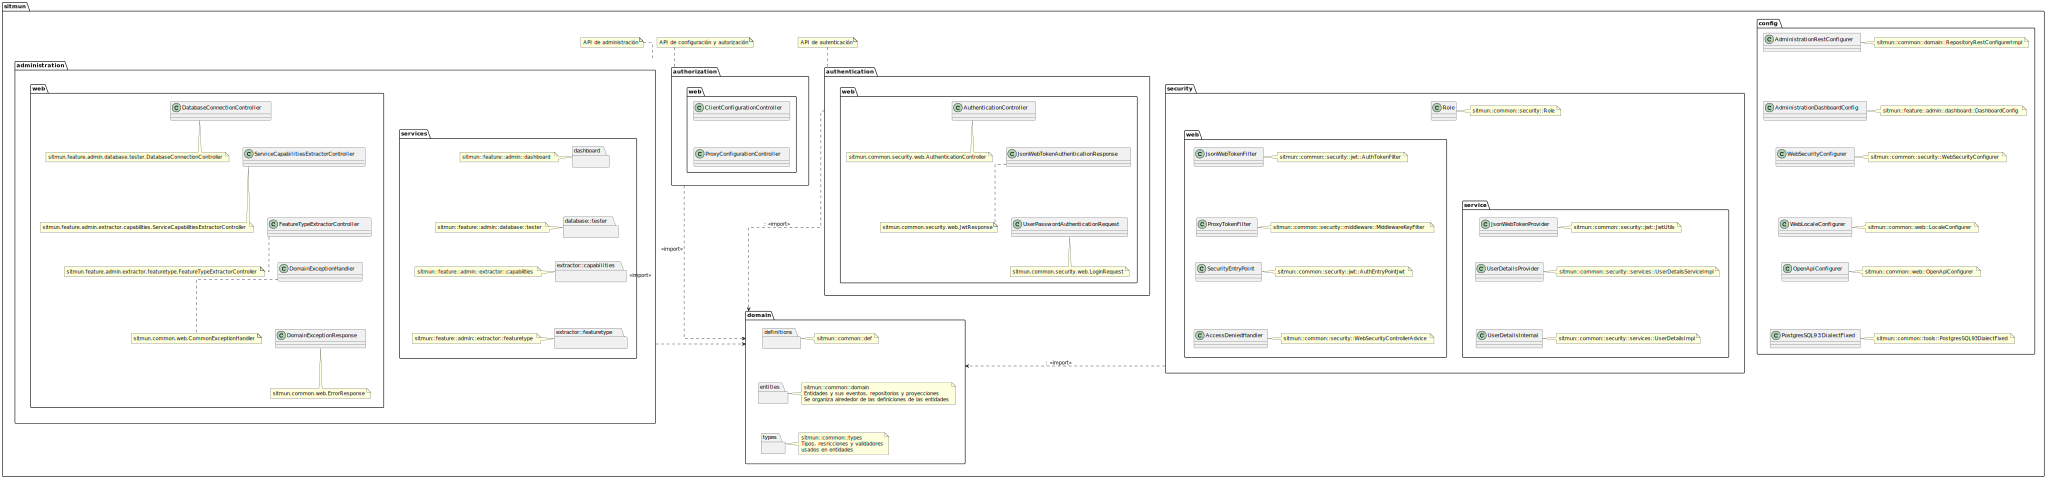

In [ ]:
%%plantuml
' HIDDEN
@startuml Refactor
skinparam linetype ortho
package sitmun {
    package authentication {
        package web {
            class AuthenticationController
            note bottom of AuthenticationController
               sitmun.common.security.web.AuthenticationController
            end note
            class JsonWebTokenAuthenticationResponse
            note bottom of JsonWebTokenAuthenticationResponse
               sitmun.common.security.web.JwtResponse
            end note
            class UserPasswordAuthenticationRequest
            note bottom of UserPasswordAuthenticationRequest
               sitmun.common.security.web.LoginRequest
            end note

            AuthenticationController-d[hidden]->JsonWebTokenAuthenticationResponse
            JsonWebTokenAuthenticationResponse-d[hidden]->UserPasswordAuthenticationRequest
        }
    }
    note top of authentication 
      API de autenticación
    end note
    package authorization {
        package web {
            class ClientConfigurationController
            class ProxyConfigurationController

            ClientConfigurationController-d[hidden]->ProxyConfigurationController
        }
    }
    note top of authorization 
      API de configuración y autorización
    end note
    package administration {
        package web {
            class DatabaseConnectionController
            note bottom: sitmun.feature.admin.database.tester.DatabaseConnectionController
            class ServiceCapabilitiesExtractorController
            note bottom: sitmun.feature.admin.extractor.capabilities.ServiceCapabilitiesExtractorController
            class FeatureTypeExtractorController   
            note bottom: sitmun.feature.admin.extractor.featuretype.FeatureTypeExtractorController
            class DomainExceptionHandler
            note bottom: sitmun.common.web.CommonExceptionHandler    
            class DomainExceptionResponse
            note bottom: sitmun.common.web.ErrorResponse    

            DatabaseConnectionController-d[hidden]->ServiceCapabilitiesExtractorController
            ServiceCapabilitiesExtractorController-d[hidden]->FeatureTypeExtractorController
            FeatureTypeExtractorController-d[hidden]->DomainExceptionHandler
            DomainExceptionHandler-d[hidden]->DomainExceptionResponse
        }
        package services {
            package dashboard {
                
            }
            note left of dashboard 
              sitmun::feature::admin::dashboard
            end note
            package "database::tester" {
                
            }
            note left of "database::tester"
              sitmun::feature::admin::database::tester
            end note
            package "extractor::capabilities" {
                
            }
            note left of "extractor::capabilities"  
              sitmun::feature::admin::extractor::capabilities
            end note
            package "extractor::featuretype" {
                
            }
            note left of "extractor::featuretype"  
              sitmun::feature::admin::extractor::featuretype
            end note

            dashboard-d[hidden]->"database::tester"
            "database::tester"-d[hidden]->"extractor::capabilities"
            "extractor::capabilities"-d[hidden]->"extractor::featuretype"
        }
        web-d[hidden]->services
    }
    note top of administration 
      API de administración
    end note

    authentication-r[hidden]>authorization
    authorization-r[hidden]>administration

    package config {
            class AdministrationRestConfigurer
            note right: sitmun::common::domain::RepositoryRestConfigurerImpl
            class AdministrationDashboardConfig
            note right: sitmun::feature::admin::dashboard::DashboardConfig    
            class WebSecurityConfigurer
            note right: sitmun::common::security::WebSecurityConfigurer           
            class WebLocaleConfigurer
            note right: sitmun::common::web::LocaleConfigurer           
            class OpenApiConfigurer
            note right: sitmun::common::web::OpenApiConfigurer           
            class PostgresSQL93DialectFixed
            note right: sitmun::common::tools::PostgresSQL93DialectFixed

            AdministrationRestConfigurer -d[hidden]-> AdministrationDashboardConfig
            AdministrationDashboardConfig -d[hidden]-> WebSecurityConfigurer
            WebSecurityConfigurer -d[hidden]-> WebLocaleConfigurer
            WebLocaleConfigurer -d[hidden]-> OpenApiConfigurer
            OpenApiConfigurer -d[hidden]-> PostgresSQL93DialectFixed
    }
    package security {
        class Role
        note right: sitmun::common::security::Role
        package web {
            class JsonWebTokenFilter
            note right: sitmun::common::security::jwt::AuthTokenFilter
            class ProxyTokenFilter
            note right: sitmun::common::security::middleware::MiddlewareKeyFilter
            class SecurityEntryPoint
            note right: sitmun::common::security::jwt::AuthEntryPointJwt
            class AccessDeniedHandler
            note right: sitmun::common::security::WebSecurityControllerAdvice

            JsonWebTokenFilter-d[hidden]->ProxyTokenFilter
            ProxyTokenFilter-d[hidden]->SecurityEntryPoint
            SecurityEntryPoint-d[hidden]->AccessDeniedHandler
        }
        package service {
            class JsonWebTokenProvider
            note right: sitmun::common::security::jwt::JwtUtils
            class UserDetailsProvider
            note right: sitmun::common::security::services::UserDetailsServiceImpl
            class UserDetailsInternal
            note right: sitmun::common::security::services::UserDetailsImpl

            JsonWebTokenProvider-d[hidden]->UserDetailsProvider
            UserDetailsProvider-d[hidden]->UserDetailsInternal

        }

        Role-d[hidden]->web
        web-d[hidden]->service
    }
    package domain {
        package definitions {
        }
        note right of definitions
          sitmun::common::def
        end note
        package entities {
        }
        note right of entities
          sitmun::common::domain
          Entidades y sus eventos, repositorios y proyecciones
          Se organiza alrededor de las definiciones de las entidades
        end note
        package types {            
        }
        note right of types
          sitmun::common::types
          Tipos, resricciones y validadores
          usados en entidades
        end note

        definitions -d[hidden]-> entities
        entities -d[hidden]-> types
    }

    administration...d.>domain: <<import>>
    authorization....d.>domain: <<import>>
    authentication....d.>domain: : <<import>>
    security....d.>domain: : <<import>>
} 

@enduml


' HIDDEN
## Ideas de la funcionalidad del proxy y diseño preliminar de la API
<https://docs.google.com/document/d/1XZGRjrcYq9sKMkJfFa61760Mi6-3i2w1VYGgy2vkpvM/edit#heading=h.7kqy9ru30l4z>

<https://docs.google.com/document/d/193w29q6CpgctsSx4Zn7iRtxR1B-EU9f1JqNNITk0ISg/edit?usp=sharing>
